# Bitcoin analysis

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [ ]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.9+9-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
E: Invalid operation wget
--2023-12-06 20:23:40--  https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 13.35.35.27, 13.35.35.94, 13.35.35.56, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|13.35.35.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251438 (246K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.3-spark3.5-s_2.13.jar.1’

graphframes-0.8.3-s 100%[===================>] 245.54K  --.-KB/s    in 0.01s   

2023-12-06 20:23:40 (17.1 MB/s) - ‘graphframes-0.8.3-spark3.5-s_2.13.jar.1’ saved [251438/251438]

mkdir: cannot create directory ‘checkpoint’: File exists


## Setup

The following cell will import the used packages.

In [ ]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

## Dataset

In this project, the task is to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/ADA_HKxML/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [ ]:
#DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/ADA_HKxML/sbe2324ada"

# Small dataset
#TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
TXDATA_FILE = "234001-247000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [ ]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769663
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661019
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445208
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3848932
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3771780
First block : 300001
Last block : 310000
First date : 2014-03-09 19:48:36
Last date : 2014-07-09 23:04:51
FILENAME : 310001-320000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4147030
First block : 310001
Last block : 320000
First date : 2014-07-08 20:02:05
Last date : 2014-09-10 13:59:57
FILENAME : 320001-329999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 5006946
First block : 320001
Last block : 329999
First date : 2014-09-06 19:01:22
Last date : 2014-11-14 16:39:17
FILENAME : 330000-337000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4092892
First block : 330000
Last block : 337000
First date : 2014-11-12 23:15:18
Last date : 2015-01-01 19:51:07
FILENAME : 337001-343000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3779208
First block : 337001
Last block : 343000
First date : 2014-12-28 23:00:04
Last date : 2015-02-11 12:21:27
FILENAME : 343001-349000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4014279
First block : 343001
Last block : 349000
First date : 2015-01-30 02:41:44
Last date : 2015-03-24 10:59:08
FILENAME : 349001-354000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3602785
First block : 349001
Last block : 354000
First date : 2015-03-22 20:13:14
Last date : 2015-04-27 23:53:38
FILENAME : 354001-360000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4389567
First block : 354001
Last block : 360000
First date : 2015-04-22 17:49:15
Last date : 2015-06-08 14:08:27
FILENAME : 360001-364000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3278880
First block : 360001
Last block : 364000
First date : 2015-06-04 19:47:52
Last date : 2015-07-05 22:45:33
FILENAME : 364001-367000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2693620
First block : 364001
Last block : 367000
First date : 2015-07-04 17:58:29
Last date : 2015-07-26 02:55:28
FILENAME : 367001-369999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2427472
First block : 367001
Last block : 369999
First date : 2015-07-24 16:32:21
Last date : 2015-08-15 17:51:16


In [ ]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|           14832|        546|     68732|2009-01-15 06:08:20|2010-07-17 16:54:44|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 190001-209999.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|         4183123|     190001|    209999|2012-07-19 09:43:01|2014-03-12 22:49:29|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 210000-224000.csv.gz
+----------------+-----------+----------+-----------------

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

start_date = pd.Timestamp(2009, 1, 3, 0, 0)
end_date = pd.Timestamp(2022, 12, 31, 23, 59)


df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]


df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip", sep=",", schema=mySchema, header="true")

dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))

dataset = dataset.filter((col("Time") >= start_date) & (col("Time") <= end_date))

dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes

           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Part 0

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation. I will now compare the time for performing the computation using Spark and Pandas, and also when using the different datasets.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                      cnt_in   cnt_out       cnt
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6   204269.0  203877.0  408146.0
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp   201330.0  200994.0  402324.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   101125.0  101016.0  202141.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx    69606.0   67552.0  137158.0
1dice6YgEVBf88erBFra9BHf6ZMoyvG88    67261.0   66801.0  134062.0
1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc    57153.0   57130.0  114283.0
1VayNert3x1KzbpzMGt2qdqrAThiRovi8    54331.0   54493.0  108824.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn    53183.0   53066.0  106249.0
1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1   43548.0   43810.0   87358.0
1dice5wwEZT2u6ESAdUGG6MHgCpbQqZiy    42620.0   42009.0   84629.0
Runtime = 323.21593832969666


### Results (Pandas)

The time to process the small dataset was : **0.7010011672973633** seconds.

The time to process the large dataset was : **323.21593832969666** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+------------------------------------+------+------+-------+
|addr                                |cnt   |cnt_in|cnt_out|
+------------------------------------+------+------+-------+
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6' |408146|204269|203877 |
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp' |402324|201330|200994 |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw' |202141|101125|101016 |
|'1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx' |137158|69606 |67552  |
|'1dice6YgEVBf88erBFra9BHf6ZMoyvG88' |134062|67261 |66801  |
|'1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc' |114283|57153 |57130  |
|'1VayNert3x1KzbpzMGt2qdqrAThiRovi8' |108824|54331 |54493  |
|'1dice7W2AicHosf5EL3GFDUVga7TgtPFn' |106249|53183 |53066  |
|'1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1'|87358 |43548 |43810  |
|'1dice5wwEZT2u6ESAdUGG6MHgCpbQqZiy' |84629 |42620 |42009  |
+------------------------------------+------+------+-------+

Runtime = 130.21375250816345


### Results (Spark)

The time to process the small dataset was : **6.75394606590271** seconds.

The time to process the large dataset was : **130.21375250816345** seconds.



### Discussion:

Pandas typically outperforms Spark when dealing with small datasets due to its in-memory computation which is faster and doesn't involve the overhead of a distributed system. However, as the size of the dataset grows, Pandas becomes less efficient because it is constrained by the single machine's memory and computational power. On the other hand, Spark, designed for distributed computing, initially has more overhead due to task distribution and scheduling, network communication, and fault tolerance mechanisms, which makes it slower for small datasets. Despite this, Spark's design allows it to manage large datasets more effectively by distributing tasks across multiple nodes in a cluster, leveraging parallel processing and disk storage if needed. This means Spark's processing time increases at a slower rate than Pandas' as the dataset size increases, making it better suited for larger datasets where its scalability can be fully utilized.

## Part 1

This first part consists of computing some statistics on the infomration available in the dataset.


### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
result = spark.sql( '''SELECT * FROM data
                       ORDER BY Sum DESC
                       LIMIT 10''')
result.show()

+---------+------+--------------------+--------------------+---------+-------------------+
|     TxId|Height|               Input|              Output|      Sum|               Time|
+---------+------+--------------------+--------------------+---------+-------------------+
| 235448:0|235448|['159SCycgn8weAy2...|[[['14FUkxnRMXexi...|  35323.8|2013-05-10 08:04:06|
| 235449:0|235449|['159SCycgn8weAy2...|[[['1JX5hS3HyVT3V...|  34323.8|2013-05-10 08:07:00|
|235450:49|235450|['159SCycgn8weAy2...|[[['14FUkxnRMXexi...|  33381.8|2013-05-10 08:10:16|
| 236542:0|236542|['159SCycgn8weAy2...|[[['1M8Zs88j3T59o...|32497.799|2013-05-17 01:22:37|
| 236648:0|236648|['19StxPcpGtY4vcq...|[[['19Sx1WtfxgQtF...|24036.418|2013-05-17 18:28:33|
| 235577:0|235577|['1Hw8dtVC9bdxDz1...|[[['1JsVdtXZHKnuz...|22693.527|2013-05-11 02:40:38|
| 238759:0|238759|['19StxPcpGtY4vcq...|[[['1EyaBWouxGsPr...|21497.215|2013-05-30 21:19:43|
| 239509:1|239509|['19StxPcpGtY4vcq...|[[['1565b5YS8ev2r...|21497.215|2013-06-03 16:46:39|

### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
# DEFINE DF

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF = transactionSDF.withColumn("Hour", hour("Time"))
transactionSDF = transactionSDF.withColumn("Time", to_date("Time"))
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


priceSDF = spark.createDataFrame(priceDF)
priceSDF = priceSDF.withColumn("Date", to_date("Date"))
priceSDF.createOrReplaceTempView("price")


# MERGE DF

spark.sql("""
    SELECT transaction.*, price.Date, price.Price, (transaction.Sum * price.Price) as USD
    FROM transaction
    INNER JOIN price ON transaction.Time = price.Date
    ORDER BY Date DESC
""").createOrReplaceTempView('transactions_bytime')


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- Time: date (nullable = true)
 |-- Hour: integer (nullable = true)



In [ ]:
# TOP 10 TRANSACTIONS

transactionsSDF_USD = spark.sql("""
    SELECT *
    FROM transactions_bytime
    ORDER BY USD DESC
    LIMIT 10
""")

transactionsSDF_USD.show()

+---------+------+---------+----------+----+----------+-----+------------------+
|     txid|height|      sum|      Time|Hour|      Date|Price|               USD|
+---------+------+---------+----------+----+----------+-----+------------------+
| 235448:0|235448|  35323.8|2013-05-10|   8|2013-05-10|117.7| 4157611.351953125|
| 235449:0|235449|  34323.8|2013-05-10|   8|2013-05-10|117.7| 4039911.351953125|
| 236542:0|236542|32497.799|2013-05-17|   1|2013-05-17|123.5|4013478.1552734375|
|235450:49|235450|  33381.8|2013-05-10|   8|2013-05-10|117.7| 3929037.951953125|
| 236648:0|236648|24036.418|2013-05-17|  18|2013-05-17|123.5| 2968497.619140625|
| 237745:0|237745|21036.477|2013-05-24|  21|2013-05-24|133.1|  2799955.03046875|
| 238759:0|238759|21497.215|2013-05-30|  21|2013-05-30|128.8|    2768841.271875|
| 238762:9|238762|  21497.0|2013-05-30|  21|2013-05-30|128.8|         2768813.6|
| 237749:1|237749|  20000.0|2013-05-24|  21|2013-05-24|133.1|         2662000.0|
| 238605:0|238605|  20589.6|

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


In [ ]:
# MERGE DF ON DATE: AGG USD, BTC and COUNT transactions

transactionsSDF_bydate = spark.sql("""
    SELECT
        Date,
        COUNT(TxId) AS Transaction_Count,
        SUM(Sum) AS Sum_BTC,
        SUM(USD) AS Sum_USD
    FROM transactions_bytime
    GROUP BY Date
    ORDER BY Date
""").createOrReplaceTempView('transactions_grouped')

transactionsSDF_bydate_pd = spark.sql("SELECT * FROM transactions_grouped").toPandas()



# MOVING AVERAGE
transactionsSDF_sma = spark.sql("""
    SELECT
        Date,
        AVG(Sum_BTC) OVER (PARTITION BY Date ORDER BY Date ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS BTC_sma,
        AVG(Sum_USD) OVER (PARTITION BY Date ORDER BY Date ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS USD_sma,
        AVG(Transaction_Count) OVER (PARTITION BY Date ORDER BY Date ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS Transactions_sma
    FROM
        transactions_grouped
""")

movingAvgPDF_pd = transactionsSDF_sma.toPandas()

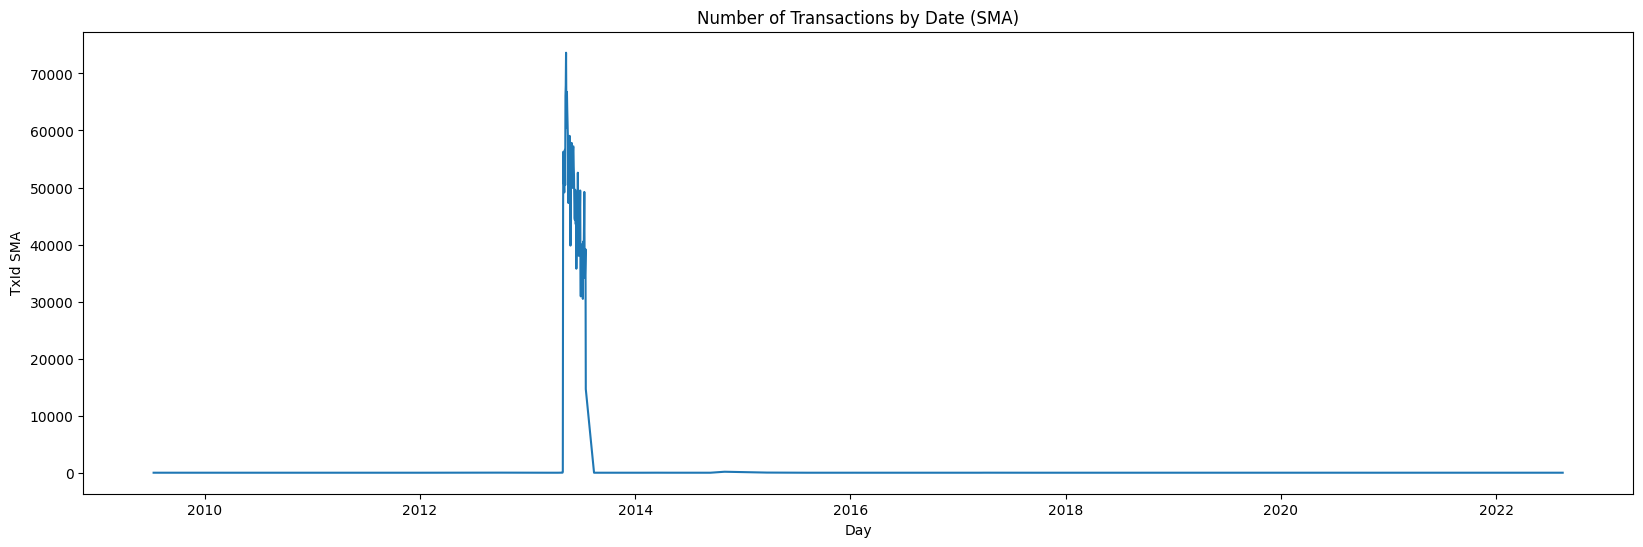

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(movingAvgPDF_pd['Date'], movingAvgPDF_pd['Transactions_sma'])
plt.title('Number of Transactions by Date (SMA)')
plt.xlabel('Day')
plt.ylabel('TxId SMA')
plt.show()

In [ ]:
start_date_filter = pd.Timestamp('2013-01-01')
end_date_filter = pd.Timestamp('2013-12-31')

movingAvgPDF_pd_filtered = movingAvgPDF_pd[(movingAvgPDF_pd['Date'] >= start_date_filter) & (movingAvgPDF_pd['Date'] <= end_date_filter)]

<ipython-input-31-edb5a2f518f7>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  movingAvgPDF_pd_filtered = movingAvgPDF_pd[(movingAvgPDF_pd['Date'] >= start_date_filter) & (movingAvgPDF_pd['Date'] <= end_date_filter)]


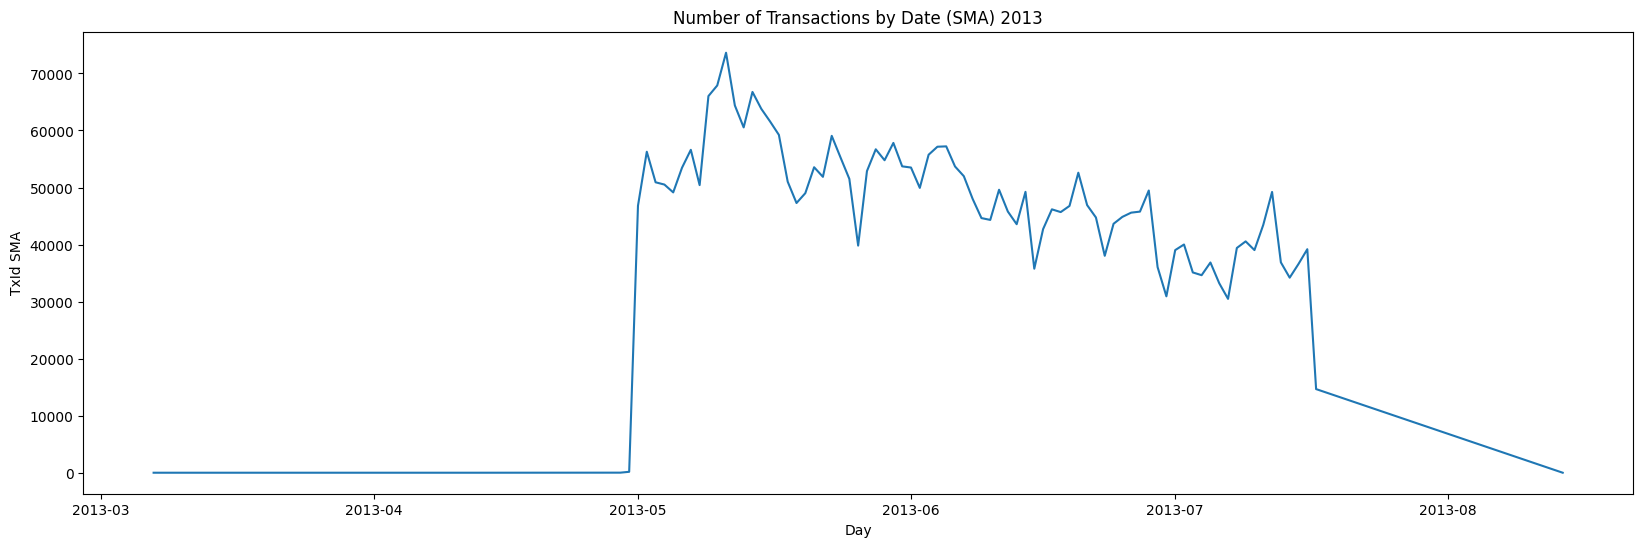

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(movingAvgPDF_pd_filtered['Date'], movingAvgPDF_pd_filtered['Transactions_sma'])
plt.title('Number of Transactions by Date (SMA) 2013')
plt.xlabel('Day')
plt.ylabel('TxId SMA')
plt.show()

**Rationale:** Analyzing the dataset reveals that the majority of transactions occurred between the end of April and mid-July 2013. We have already tailored our dataset to reflect this period. The chart displays a Simple Moving Average (SMA) with a 7-day window. This window size is optimal for our purposes: it's large enough to diminish noise, yet sufficiently small to capture the ongoing variations in transaction numbers, highlighting an apparent downward trend.

The graph also indicates a notable scarcity of transactions before the surge at the end of April. Additionally, the SMA results in a linear trend towards the end of the graph. This suggests a lower transaction volume, which, when averaged over a longer period, does not accurately represent the activity during this later phase. The smoothing effect of the SMA over this extended duration masks the true nature of the transactional activity in this timeframe.







### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


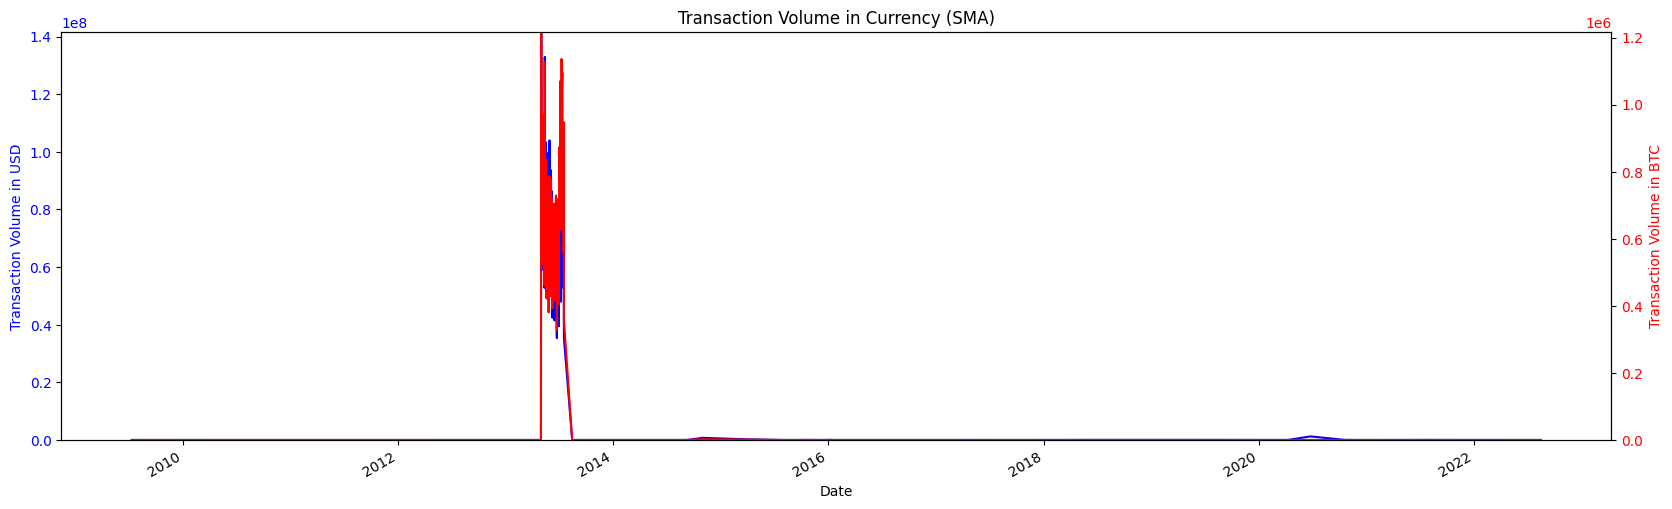

In [ ]:
plt.figure(figsize=(20, 6))
ax1 = plt.gca()

# PLOT USD_sma on primary Y-axis
ax1.plot(movingAvgPDF_pd['Date'], movingAvgPDF_pd['USD_sma'], color='b', label='USD SMA')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transaction Volume in USD', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Transaction Volume in Currency (SMA)')

# Set Y-axis limit for USD to its max value
max_usd = movingAvgPDF_pd['USD_sma'].max()
ax1.set_ylim(0, max_usd)

# PLOT BTC_sma on secondary Y-axis
ax2 = ax1.twinx()
ax2.plot(movingAvgPDF_pd['Date'], movingAvgPDF_pd['BTC_sma'], color='r', label='BTC SMA')
ax2.set_ylabel('Transaction Volume in BTC', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set Y-axis limit for BTC to its max value
max_btc = movingAvgPDF_pd['BTC_sma'].max()
ax2.set_ylim(0, max_btc)

# Optionally, format the x-axis to better display datetime
plt.gcf().autofmt_xdate()

plt.show()


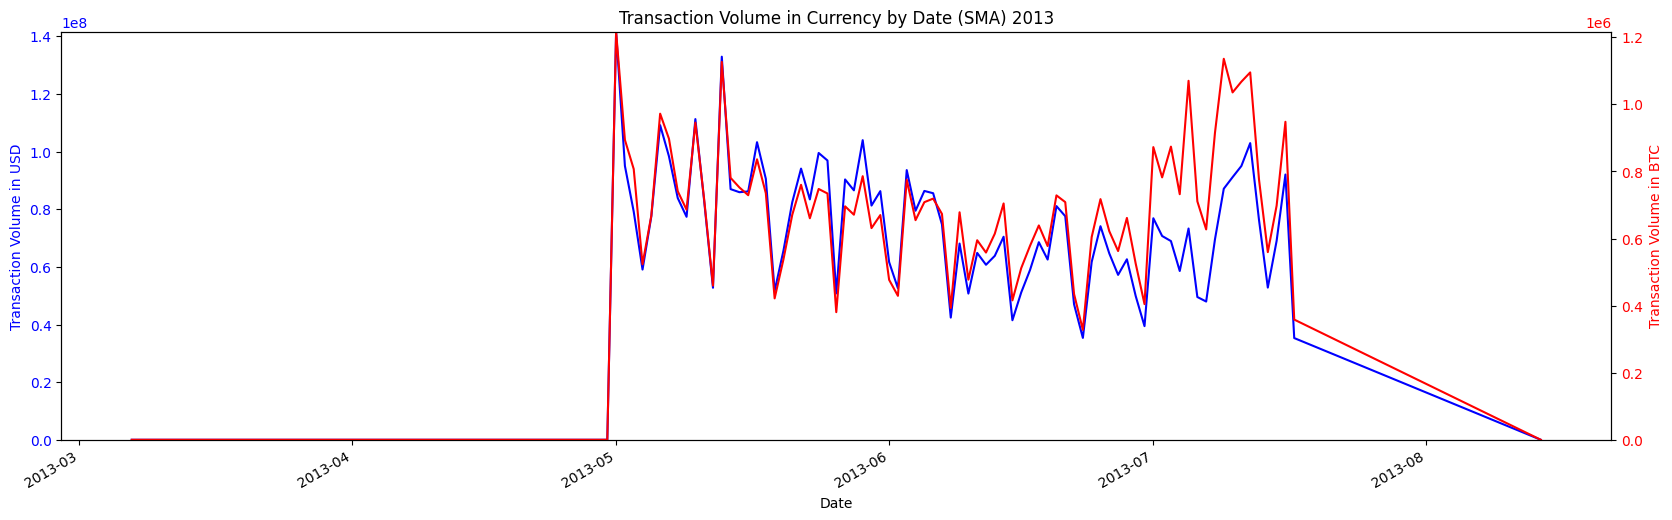

In [ ]:
plt.figure(figsize=(20, 6))
ax1 = plt.gca()

# PLOT USD_sma on primary Y-axis
ax1.plot(movingAvgPDF_pd_filtered['Date'], movingAvgPDF_pd_filtered['USD_sma'], color='b', label='USD SMA')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transaction Volume in USD', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Transaction Volume in Currency by Date (SMA) 2013')

# Set Y-axis limit for USD to its max value
max_usd = movingAvgPDF_pd_filtered['USD_sma'].max()
ax1.set_ylim(0, max_usd)

# PLOT BTC_sma on secondary Y-axis
ax2 = ax1.twinx()
ax2.plot(movingAvgPDF_pd_filtered['Date'], movingAvgPDF_pd_filtered['BTC_sma'], color='r', label='BTC SMA')
ax2.set_ylabel('Transaction Volume in BTC', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set Y-axis limit for BTC to its max value
max_btc = movingAvgPDF_pd_filtered['BTC_sma'].max()
ax2.set_ylim(0, max_btc)

# Optionally, format the x-axis to better display datetime
plt.gcf().autofmt_xdate()

plt.show()


**Rationale:** The graph is visual representation of the transaction volumes in both USD and BTC currencies, revealing how each currency's transaction volume fluctuates over time within the year 2013. The use of a 7-day rolling window for the SMA serves to dampen daily volatility, granting us a clearer view of the medium-term trends. Notably, the graph showcases points where the SMA trends for USD and BTC intersect. These intersections are significant, as they suggest moments where the relative transaction volumes of USD and BTC align. However, it's crucial to acknowledge that these intersections do not imply equal transaction volumes but merely an equivalence in their average movements over the chosen period, as each currency's trend line operates on a distinct y-axis scale.

During the span of March to August 2013, both USD and BTC transaction volumes exhibit peaks and troughs, indicative of the market's reactive nature to external factors, possibly including economic events or shifts in trader sentiment. The USD transaction volume, in particular, shows heightened activity around the end of April, which could correlate with significant market events or news specific to that period.

As the graph progresses towards August, a downward trend becomes more discernible, particularly in the BTC transaction volume. This trend could reflect a period of market correction or reduced trading activity. The SMA's linear progression in this phase suggests a period of consolidation or a possible decline in market transactions, which might not fully capture shorter-term volatilities or sudden market movements.



## Part 2

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

In [ ]:
# INDEX 1: Balance

def balance(balanceInput_df):
  balance_dict = {}
  for index, row in balanceInput_df.iterrows():
    inp = row["Input"]
    out = row["Output"]

    # Loop throug input addresses
    for input_address in inp:
      if input_address not in balance_dict:
        balance_dict[input_address] = 0
      balance_dict[input_address] = 0

    # Loop through output addresses
    for output_address, output_value in out:
      if output_address not in balance_dict:
        balance_dict[output_address] = output_value
      else:
        balance_dict[output_address] += output_value

  resultDF = pd.DataFrame.from_dict(balance_dict, orient="index").reset_index()


  resultDF.columns = ["Address", "Balance"]

  return resultDF

balanceDF = balance(df)
balanceDF

,Address,Balance
0,15NGhVUjBAanNfRZotFb3F5j2vmrpuv3b7,0.000000
1,18qA3uhSDwR1hV7rZwMqnRNW8T82sckurK,4.643242
2,1EMCxdwjSqgMkv656iXd52SN598wKE89yp,0.000000
3,1FU119XTyzm4iAATCcenaSTp92FM2jRFtm,0.000000
4,1GZcVpU4tDA1feWVWvdQk5xXoYQmHjW99b,0.000000
...,...,...
2996732,1DnUp55UuBs1LgGV78BYsxPQGBACfKdFbj,11.673663
2996733,1J5V7k1Aj2TgGZg3L8x21cHyY6jAek4aH6,0.100314
2996734,174jmZ17fQesbUQPLP4TYurLDq1RU1Pace,0.033428
2996735,1ML924CrYQkQWBrubasJzrufhUXr7uX32b,0.023270


**Rationale:** Computing the balance for bitcoin transaction is not a normal balance-calculation. The reason is that once an address appears as an input address, it has to send all the bitcoins that it has, thus setting the balance of that particular address back to zero. This, however, does not imply that there is nothing on the balance of that address after the transaction, because self-transactions are possible.

While creating the balance index, we kept those specialities for bitcoin-balance-computation in mind. In order to find the balance of each and every address we start by building up a dictionary. The goal is to have each and every address as a key in the dictionary and the running balance value as a respective value.

To reach that, we first loop through every transaction. Within each transaction, we firstly loop through the inputs and set the balance equal to zero for every address appearing. If the input address was not yet a key in our dictionary, we store it with a running balance value of 0 in it. After that, we loop through the output. If we come along an address that is already known, we simply add the output value of that particular address to its dictionaries value. If we, however, come along an unknown address, we create a new key and value with the respective entries.

The final step is then transforming the dictionary to a dataframe.

In [ ]:
# INDEX 2: Top3 partners

# MERGE ON TxId and Time

auxDF = pd.merge(outputDF[["TxId","Output","Time"]], inputDF[["TxId","Input","Time"]], on=['TxId', 'Time'], how='outer')
auxDF = auxDF[['TxId', 'Time', 'Output', 'Input']]
auxDF = auxDF.drop_duplicates(subset=['TxId', 'Time', 'Output', 'Input'])


# NORMALIZE DF TO COUNT FREQUENCEY OF UNDIRECTED PAIRS (A-B is the same pair as B-A)

auxDF['Pair'] = auxDF.apply(lambda row: tuple(sorted([row['Input'], row['Output']])), axis=1)


# COUNT FREQUENCEY OF UNDIRECTED PAIRS

auxDF = auxDF.groupby('Pair').agg(Combined_Frequency=("TxId", "count")).reset_index()
auxDF['Address'], auxDF['Partner'] = zip(*auxDF['Pair'])


# INCLUDE FREQUENCY IN BOTH DIRECTIONS

auxDF = auxDF[['Address', 'Partner', 'Combined_Frequency']]

auxInvDF = auxDF[['Partner', 'Address', 'Combined_Frequency']].rename(columns={'Partner': 'Address', 'Address': 'Partner'})


all_partnersDF = pd.concat([auxDF, auxInvDF], ignore_index=True)
all_partnersDF.drop_duplicates(inplace = True)

all_partnersDF = all_partnersDF.sort_values(by='Combined_Frequency', ascending=False)
top3_partnersDF = all_partnersDF.groupby("Address").head(3)
top3_partnersDF

,Address,Partner,Combined_Frequency
10145014,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,54196
7003761,1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1,1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1,43547
19596423,1dice6YgEVBf88erBFra9BHf6ZMoyvG88,1KGBhwojYViF3rL7x85rmoQve7ohwaGgo9,17565
9432538,1KGBhwojYViF3rL7x85rmoQve7ohwaGgo9,1dice6YgEVBf88erBFra9BHf6ZMoyvG88,17565
10409692,1CrAcKt3HE8LNsx4KKDvjqLvcr373wg5ke,12CDvRT86CRVbq6E9U95QFenHKWizXDaHj,16562
...,...,...,...
6894935,1CCJxXqG2ahNEezxshJ2hWUBBNSixkehBc,1PZEGooPJgR2DAYTTFuFJTGwGDDVnJG5bt,1
6894925,1CCJr9HFMb4HiG8uXYjF4o6dmK55CS1KTq,1HohNPmhmG75fmYSdRtZFPyGC24DkQsfc1,1
6894929,1CCJsnTocoCZ6CAcirzXihZdHpxqMX4Yaj,1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc,1
6894928,1CCJsnTocoCZ6CAcirzXihZdHpxqMX4Yaj,1Cd8QmCtZ4WexWSsYY9zY7dfmcaGLVAvrE,1


**Rationale:** In order to provide an index showing the top three business partners (as in addresses) for each address, whether provided in input or output, we have first created every given combination by joining our input and output DataFrame on TxId and Time with an outer join to include all records from both DataFrames.

In the next stage we create a pair out of each given input and output. Than we create an inverted version of our table, as the count for combinations of business partners goes from inout to output, as well as output to input. In written: The transactions A to B, and B to A should count two for counting A’s partner B and vice versa. Finally we can sort our data and show the top three business partners by address based on the frequency they appeared in.


In [ ]:
top3_partnersDF[top3_partnersDF["Address"] == "1VayNert3x1KzbpzMGt2qdqrAThiRovi8"]

,Address,Partner,Combined_Frequency
10145014,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,54196
18143143,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,1EeCGpVttBiRyaeXxTtLAiQdrqpgQ3jsEQ,885
11057396,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,12z9w8cjihpQxzyL1UGBsVe4iRjYNsGURf,278


As this index was built for a website, the "search function" is a bit different than the one for the other two statistics. If we want to know the top three for e.g. address "1VayNert3x1KzbpzMGt2qdqrAThiRovi8", we just have to filter the top3_partnersDF, looking only at the rows, where "Address" == "1VayNert3x1KzbpzMGt2qdqrAThiRovi8".

An example with the aforementioned address is shown above.

In [ ]:
# INDEX 3: Average transaction value received in USD

# MERGE OUTPUT DF WITH BTC PRICE TO CALCULATE USD VALUE (TIME)

outputDF["Date"] = outputDF.Time.dt.date
outputDF["Date"] = pd.to_datetime(outputDF["Date"], errors="coerce")

transaction_valueDF = outputDF.set_index("Date").join(priceDF.set_index("Date"), how = "left").reset_index()
transaction_valueDF['USD_value'] = transaction_valueDF['Value'] * transaction_valueDF['Price']


# GROUP BY OUTPUT & AGG AVG VALUE

transaction_valueDF = transaction_valueDF.groupby('Output')['USD_value'].mean()

print(transaction_valueDF.sort_values(ascending=False))

Output
1EyaBWouxGsPrNLWstRtUkQrj88djsFJeY    2.768814e+06
1B1QnrLSm6edKNkp1yHKj4qt1RCzZ4mvEU    2.651940e+06
1565b5YS8ev2r3XcedNchAo8f413o1fwM7    2.594688e+06
1JsVdtXZHKnuzUihEjCPyRm5EEcxRjWGEh    2.427600e+06
1M2TBBkAESfiyKsmqDKsLxD6oC4bvM8WQx    2.291916e+06
                                          ...     
1PFkfUWRjRB9CcWmebBDo36E3pQBy8GgTV    6.850000e-07
18LDFsbMmjA87kMke6H3tHnF5iEhepttdT    3.302857e-07
1PKmSCXkcn9bryhnm7ULhxAD7pEwXe6v9u    3.302857e-07
1EduDNkkioGJjv8AqUspCSDwRDYfUw1bW2    0.000000e+00
15LLbG8dDyH4JjAM7yJbYaK3kJXPN9vxai    0.000000e+00
Name: USD_value, Length: 2887464, dtype: float64


**Rationale:** In order to show the average transaction received value we merged our outputDF, which shows respective value in BTC received, with our BTC price DataFrame. We can calculate the USD value of transactions received and on top the average received value per transaction. In our table we can see large gap between our max and min average transaction values.

## Part 3

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.


### Building the Statistics (Features)

In [ ]:
# Larger dataset
DATASET_DIR_labels = "/content/drive/MyDrive/ADA_HKxML/sbe2324ada/labels"
TXDATA_FILE_labels = "labels-234001-247000.csv.gz"

date_cols = ["date_first_tx"]
path = os.path.join(DATASET_DIR_labels, TXDATA_FILE_labels)
labelsDF = pd.read_csv(path, compression='gzip', parse_dates=date_cols)
labelsDF['address'] = labelsDF['address'].apply(ast.literal_eval)

In [ ]:
# Calculating statistics

"""-------------------------------
Calculating independent statistics
-------------------------------"""

# stats retrieved from inputDF
inputDF["Date"] = inputDF.Time.dt.date
inputDF["Date"] = pd.to_datetime(inputDF["Date"], errors="coerce")
inputStats_df = inputDF.groupby("Input").agg(Appearances_input=("Height", "count"),
                                             First_appearance_input=("Date", "min"),
                                             Last_appearance_input=("Date", "max")).reset_index()

# stats retrieved from outputDF & priceDF
outputDF["Date"] = outputDF.Time.dt.date
outputDF_dollar = outputDF.set_index("Date").join(priceDF.set_index("Date"), how = "left").reset_index()
outputDF_dollar["Value_dollar"] = outputDF_dollar["Value"] * outputDF_dollar["Price"]

outputStats_df = outputDF_dollar.groupby("Output").agg(Appearances_output=("Height", "count"),
                                                       First_appearance_output=("Date", "min"),
                                                       Last_appearance_output=("Date", "max"),
                                                       Total_received_BTC=("Value", "sum"),
                                                       Total_received_dollar=("Value_dollar", "sum"),
                                                       Max_received_BTC =("Value", "max"),
                                                       Max_received_dollar = ("Value_dollar", "max"),
                                                       Std_received_BTC=("Value", "std"),
                                                       Std_received_dollar=("Value_dollar", "std")
                                                       ).reset_index()

# NOTE: If address is in input and output, this implies that this address sent sth. to itself. Thus, there is a bias in the output Stats!

# average amount received BTC & dollar
outputStats_df["Average_received_BTC"] = outputStats_df["Total_received_BTC"] / outputStats_df["Appearances_output"]
outputStats_df["Average_received_dollar"] = outputStats_df["Total_received_dollar"] / outputStats_df["Appearances_output"]

# total number of transactions
# Rename columns to prepare for concatination
outputDF_renamed = outputDF.rename(columns={"Output": "Address"})
inputDF_renamed = inputDF.rename(columns={"Input": "Address"})

numTransactionsDF = pd.concat([inputDF_renamed[["TxId", "Address"]], outputDF_renamed[["TxId", "Address"]]]).drop_duplicates().reset_index(drop = True)
numTransactionsDF = numTransactionsDF.groupby("Address").agg(Num_Transactions=("TxId", "count")).reset_index()

# Number of Transaction-Partners
numPartnerDF = all_partnersDF.groupby("Address").agg(Num_Transaction_partners=("Partner", "count")).reset_index()

# Number of self-transactions
self_transactions = all_partnersDF[all_partnersDF['Address'] == all_partnersDF['Partner']]
self_transactions = self_transactions.groupby('Address').agg(Self_Transaction_Count=("Combined_Frequency", "sum")).reset_index()



"""------------------------------------------------
Combining all collected statistics in one dataframe
------------------------------------------------"""

statisticsDF = inputStats_df.set_index("Input").join(outputStats_df.set_index("Output"), how = "outer").reset_index(names="Address")
statisticsDF = statisticsDF.set_index("Address").join(numTransactionsDF.set_index("Address")).reset_index(names="Address")
statisticsDF = statisticsDF.set_index("Address").join(numPartnerDF.set_index("Address")).reset_index(names="Address")
statisticsDF = statisticsDF.set_index("Address").join(self_transactions.set_index("Address")).reset_index(names="Address")

# filling all missing values
featuresToFill = ["Appearances_input",
                  "Appearances_output",
                  "Total_received_BTC",
                  "Total_received_dollar",
                  "Average_received_BTC",
                  "Average_received_dollar",
                  "Max_received_BTC",
                  "Max_received_dollar",
                  "Self_Transaction_Count",
                  "Std_received_BTC",
                  "Std_received_dollar"]
statisticsDF[featuresToFill] = statisticsDF[featuresToFill].fillna(0)



"""------------------------------------------
Calculating statistics using other statistics
------------------------------------------"""

# Total appearances
statisticsDF["Total_appearances"] = statisticsDF["Appearances_input"] + statisticsDF["Appearances_output"]

# Replace NaT with the future date, find the minimum, then replace the future date back with NaT
future_date = pd.Timestamp('2099-12-31')
past_date = pd.Timestamp('1900-01-01')

statisticsDF["First_appearance"] = np.minimum(
    statisticsDF["First_appearance_input"].fillna(future_date),
    statisticsDF["First_appearance_output"].fillna(future_date)
).replace(future_date, pd.NaT)

statisticsDF["Last_appearance"] = np.maximum(
    statisticsDF["Last_appearance_input"].fillna(past_date),
    statisticsDF["Last_appearance_output"].fillna(past_date)
).replace(pd.Timestamp('1900-01-01'), pd.NaT)

# Number of active days and number of Transactions over active time
statisticsDF['Active_days'] = 1 + (statisticsDF['Last_appearance'] - statisticsDF['First_appearance']).dt.days
statisticsDF['Transactions_per_Day'] = statisticsDF['Num_Transactions'] / statisticsDF['Active_days']

# Self transaction rate
statisticsDF['self_send_rate'] = statisticsDF['Self_Transaction_Count'] / statisticsDF['Num_Transactions']

# Maturity DataSet
statisticsDF['Maturity_dataset']  = (statisticsDF['First_appearance'] - statisticsDF['First_appearance'].min()).dt.days
statisticsDF['Maturity_btc']  = (statisticsDF['First_appearance'] - pd.to_datetime("2012-01-12")).dt.days

# Apperance Input Ratio
statisticsDF['Appearance_input_ratio'] = statisticsDF['Appearances_input'] / statisticsDF['Total_appearances']



"""-----------------------
Joining further dataframes
-----------------------"""

# Joining with the balanceDF
statisticsDF = statisticsDF.set_index("Address").join(balanceDF.set_index("Address")).reset_index(names="Address")

# Joining the statisticsDF with the labelsDF
statisticsDF = statisticsDF.set_index("Address").join(labelsDF[["address", "type"]].set_index("address"), how = "inner").reset_index(names="Address")



"""--------------------------
Final changes to statisticsDF
--------------------------"""

# Reordering columns

OrderedStats = ["Address",
                "type",
                "Balance",
                "Active_days",
                "Transactions_per_Day",
                "Num_Transactions",
                "Self_Transaction_Count",
                "self_send_rate",
                "Num_Transaction_partners",
                "First_appearance_input",
                "Last_appearance_input",
                "Appearance_input_ratio",
                "Appearances_input",
                "First_appearance_output",
                "Last_appearance_output",
                "Appearances_output",
                "Total_appearances",
                "First_appearance",
                "Last_appearance",
                "Maturity_dataset",
                "Maturity_btc",
                "Std_received_BTC",
                "Std_received_dollar",
                "Total_received_BTC",
                "Total_received_dollar",
                "Average_received_BTC",
                "Average_received_dollar",
                "Max_received_BTC",
                "Max_received_dollar"]

statisticsDF = statisticsDF[OrderedStats]
statisticsDF


,Address,type,Balance,Active_days,Transactions_per_Day,Num_Transactions,Self_Transaction_Count,self_send_rate,Num_Transaction_partners,First_appearance_input,...,Maturity_dataset,Maturity_btc,Std_received_BTC,Std_received_dollar,Total_received_BTC,Total_received_dollar,Average_received_BTC,Average_received_dollar,Max_received_BTC,Max_received_dollar
0,1121PzNgNW9TBABPKqihwfnbtSqWSBbEyV,historic,0.010001,1,1.000000,1,0.0,0.0,30,NaT,...,1447,532,0.000000,0.000000,0.010001,1.017069,0.010001,1.017069,0.010001,1.017069
1,1121ZGGc5Fhhwqz2UriGZCA5XQdt7iVKmG,service,0.000000,1,2.000000,2,0.0,0.0,9,2013-05-10,...,1399,484,0.000000,0.000000,12.339309,1452.336652,12.339309,1452.336652,12.339309,1452.336652
2,1121gjGcQgDfXUHZRiF5i8VgotVxN1JwQ6,service,0.000000,2,1.000000,2,0.0,0.0,3,2013-06-12,...,1431,516,0.000000,0.000000,1.959785,213.616513,1.959785,213.616513,1.959785,213.616513
3,1122Rsbg4wnEastUACmViUH13Da5vEoZQ7,service,0.000000,29,0.068966,2,0.0,0.0,3,2013-07-09,...,1431,516,0.000000,0.000000,1.650000,179.850000,1.650000,179.850000,1.650000,179.850000
4,1122WYHCi2vdn7gikSF9RzaX7didpEfq1x,historic,0.000000,64,0.375000,24,0.0,0.0,44,2013-05-12,...,1401,486,1.756047,184.593747,28.176150,3024.103477,2.348012,252.008623,4.659318,469.250238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243913,1zzgbmsKCrdFrC3TA3LsdSgW1HuGodJxm,service,0.000000,10,1.000000,10,0.0,0.0,16,2013-05-03,...,1390,475,6.358980,662.913955,66.930000,7527.344000,13.386000,1505.468800,23.000000,2444.900000
243914,1zzoaGLfU5sJ6PyTki3vCC46cLJ2fU8aY,service,0.000000,1,2.000000,2,0.0,0.0,3,2013-06-24,...,1444,529,0.000000,0.000000,0.188000,19.194800,0.188000,19.194800,0.188000,19.194800
243915,1zzqNoZwizQwLNboL4hDAL3ejQCusZk7j,historic,0.000000,2,1.000000,2,0.0,0.0,3,2013-05-24,...,1412,497,0.000000,0.000000,0.989500,124.973850,0.989500,124.973850,0.989500,124.973850
243916,3HqAe9LtNBjnsfM4CyYaWTnvCaUYT7v4oZ,service,0.000100,1,1.000000,1,0.0,0.0,1,NaT,...,1422,507,0.000000,0.000000,0.000100,0.012250,0.000100,0.012250,0.000100,0.012250


*Rationale:* We have calculated 27 different statistics, partially relying on previous computations for efficiency purpose operating with this large dataset. We are aware that most likely we will not use most of these statistics, however we wanted to explore them to find the best fit!

---

*Transaction-Related Statistics*

•⁠  ⁠Appearances (Total/Input/Output): Count of transactions how often a particular address appears.

•⁠  ⁠First Appearance (Total/Input/Output): Date of the first transaction for an address.

•⁠  ⁠Last Appearance (Total/Input/Output): Date of the last transaction for an address.

•⁠  ⁠Number of Transactions: Count of total transactions in which a particular address is involved.

•⁠  ⁠Number of Transaction Partners: Count of unique partners involved in transactions with the address.

•⁠  ⁠Self-Transactions (Rate/Number): Transactions that are self-sent.

---

*Output-Related Statistics*

•⁠  ⁠Total Received (BTC/Dollar): Sum of values received by an address.

•⁠  ⁠Maximum Received (BTC/Dollar): The highest single transaction value received by an address.

•⁠  ⁠Standard Deviation Received (BTC/Dollar): The standard deviation of transaction values received by an address.

•⁠  ⁠Average Received (BTC/Dollar): Average value received per transaction.

•⁠  ⁠Balance: Integrated from another dataset, and represents the current, rolling balance of an address.

----

*Time-Related Statistics*

•⁠  ⁠Active Days: Number of days between first and last appearance.

•⁠  ⁠Transactions per Day: Average number of transactions per active day.

•⁠  ⁠Maturity (Dataset/BTC): Number of days since the earliest transaction in the dataset, as well as the first BTC tranaction ever.

•⁠  ⁠Appearance Input Ratio: Proportion of appearances as input relative to total appearances.

### Feature Selection

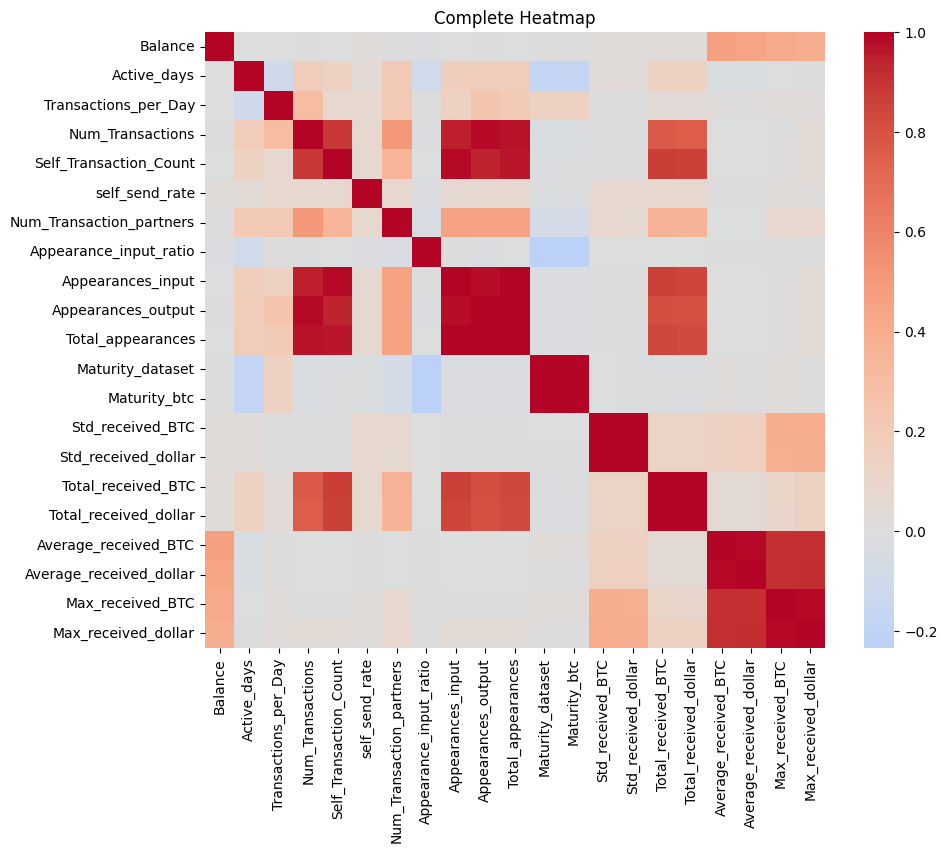

In [ ]:
# Calculate the correlation matrix and select the upper triangle of the matrix
corr = statisticsDF.select_dtypes(include='number').corr()

# Plot the heatmap for all features
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center = 0)
plt.title("Complete Heatmap")
plt.show()

**Rationale:** As we ended up with a total of 27 statistics, the next step was selecting the right ones. A model with excessive features can become overly complex and starts to "learn" the noise and specific details in the training data, rather than generalizing from the underlying patterns. In order to avoid this, we decided to eliminate correlated features, as those might lead to redundancy in information.

To do so, we first plotted all features against one another and displayed that on a heatmap as shown above.

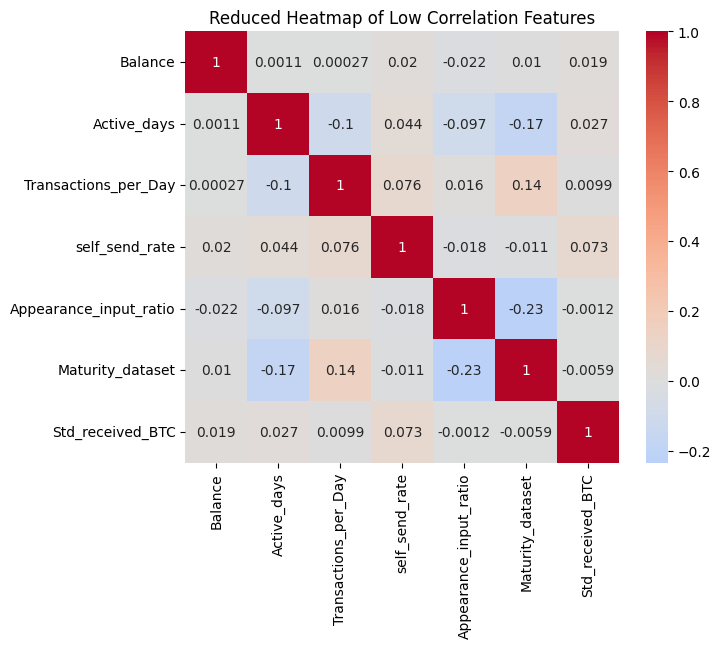

In [ ]:
threshold = 0.25
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index (column names) of features to keep
features_to_keep = [column for column in upper_tri.columns if not any((upper_tri[column] > threshold) | (upper_tri[column] < -threshold))]

# Add "Address" and "type" to the features_to_keep list
features_to_keep = ["Address", "type"] + features_to_keep

# Create a DataFrame with only the features to keep
statisticsDF = statisticsDF[features_to_keep]

# Create a correlation matrix for the reduced DataFrame
reduced_corr = statisticsDF.select_dtypes(include='number').corr()

# Plot the heatmap for the reduced set of features
plt.figure(figsize=(len(reduced_corr.columns) * 1, len(reduced_corr.columns) * 0.8))
sns.heatmap(reduced_corr, cmap='coolwarm', center=0, annot=True)
plt.title("Reduced Heatmap of Low Correlation Features")
plt.show()

**Rationale:** After having built up a correlation-heatmap for all features, we reduced the features that have a correlation of |corr| > 0.25. A threshold of 0.25 is moderate. It's not so low that it excludes potentially useful features with weak correlations, nor is it so high that it includes features with only marginal correlations. This balance can help in retaining features that are somewhat, but not strongly, correlated with the target variable. Our heuristic for feature selection is that we simply choose the first mentioned feature, when coming along a correlation with an absolute value > 0.25.

After implementing the above described logic, we end up reducing our pot of features by 20 features, resulting in 7 features, that we use for our classification algorithm in the next step. Those seven selected features are:

1. Balance

2. Active days

3. Transactions per Day

4. Self send rate

5. Appearance input ratio

6. Maturity dataset

7. Standard deviation of Bitcoins received

### Classification ALgorithm (GBC)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the 'type' column to have numerical labels
label_encoder = LabelEncoder()
statisticsDF['type'] = label_encoder.fit_transform(statisticsDF['type'])

features = statisticsDF.drop(['Address', 'type'], axis=1)

# Labels (the 'type' column)
labels = statisticsDF['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Instantiate the model with default parameters
gbm = GradientBoostingClassifier(random_state=42)

# Fit the model
gbm.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = gbm.predict(X_test)

<ipython-input-21-28eacb70cff8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statisticsDF['type'] = label_encoder.fit_transform(statisticsDF['type'])


**Rationale:** The challenge that we are facing in this classification task is not only the size of the dataset, but also the fact that we have a multi-classes classification problem. After doing some research in that field, we found that the Gradient Boosting Classifier can be particularly effective due to its ability to handle complex and high-dimensional data, ensuring accurate classification across multiple categories by iteratively refining the decision process and correcting misclassifications from earlier trees in the ensemble. For that we first split the data into one train-set and one test-set and then apply the Gradient Boosting Classifier (also in the sklearn library).

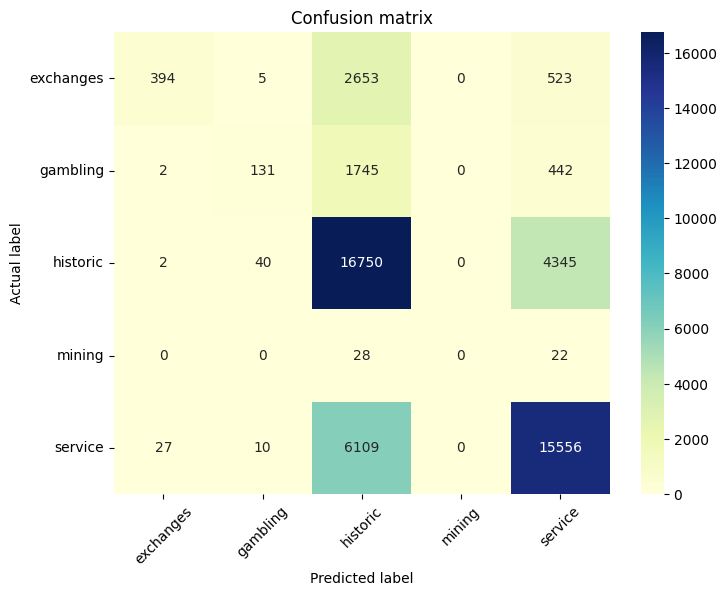

Precision: 0.6987173835586712
Recall: 0.6729870449327648
Accuracy: 0.6729870449327648


In [ ]:
# Calculate the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Getting unique class names from the 'type' column after Label Encoding
original_class_names = label_encoder.inverse_transform(np.unique(y_test))

# Set figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap for confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix, index=original_class_names, columns=original_class_names),
            annot=True, cmap="YlGnBu", fmt='g')

# Adjustments for the heatmap layout and labels
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

# Calculate precision, recall, and accuracy
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

For measuring the performance of the Gradient Boosting Classifier, we looked at the Precision, Recall, and Accurary of the classification output. Here, we can see that our classification model is moderate with all meausres touching the 70% mark. However, we also recognize that those numbers definitely show room for improvement.

Nevertheless, it is worth mentioning that the only really representative labels are "historic" and "service". The rest hast only a few, rather neglectable entries. Thus, our next step is reducing this confusion matrix to only those two labels, and then recomputing the statistics.

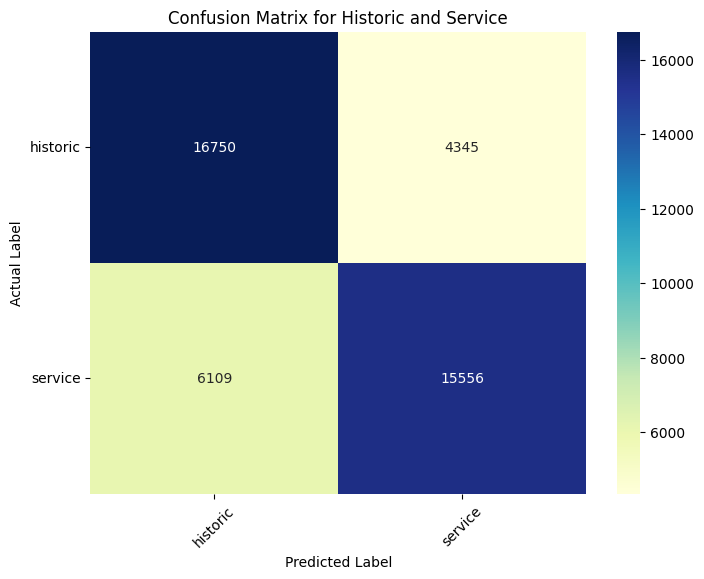

Precision: 0.7575336898315531
Recall: 0.7541259133032984
Accuracy: 0.7541259133032984


In [ ]:
# Extract indices for 'historic' and 'service' from the original_class_names
historic_index = np.where(original_class_names == 'historic')[0][0]
service_index = np.where(original_class_names == 'service')[0][0]

# Create a new confusion matrix including only 'historic' and 'service'
reduced_cnf_matrix = cnf_matrix[[historic_index, service_index]][:, [historic_index, service_index]]

# Corresponding class names for the new confusion matrix
reduced_class_names = original_class_names[[historic_index, service_index]]

# Plot the reduced confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(pd.DataFrame(reduced_cnf_matrix, index=reduced_class_names, columns=reduced_class_names),
            annot=True, cmap="YlGnBu", fmt='g')

# Set the title and axis labels
plt.title('Confusion Matrix for Historic and Service')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

# Calculating the scores
# Filter y_test and y_pred to only include indices for 'historic' and 'service'
historic_service_filter = (y_test == historic_index) | (y_test == service_index)
y_test_filtered = y_test[historic_service_filter]
y_pred_filtered = y_pred[historic_service_filter]

# Calculate precision, recall, and accuracy for the filtered labels
print("Precision:", metrics.precision_score(y_test_filtered, y_pred_filtered, labels=[historic_index, service_index], average='weighted', zero_division=0))
print("Recall:", metrics.recall_score(y_test_filtered, y_pred_filtered, labels=[historic_index, service_index], average='weighted'))
print("Accuracy:", metrics.accuracy_score(y_test_filtered, y_pred_filtered))


After the reduction of labels, we can observe a big improvement in all measurements, i.e. Precision, Recall, and Accuracy, coming from bearly touching 70% to more than 75%. This is a very moderate score.

## Part 4

Consider we didn't have the labels for the address, but that you would want to create groups of addresses.


To create groups of Bitcoin addresses without predefined labels, we can use a clustering approach. K-means clustering is an effective technique for this purpose. The process involves the following steps:

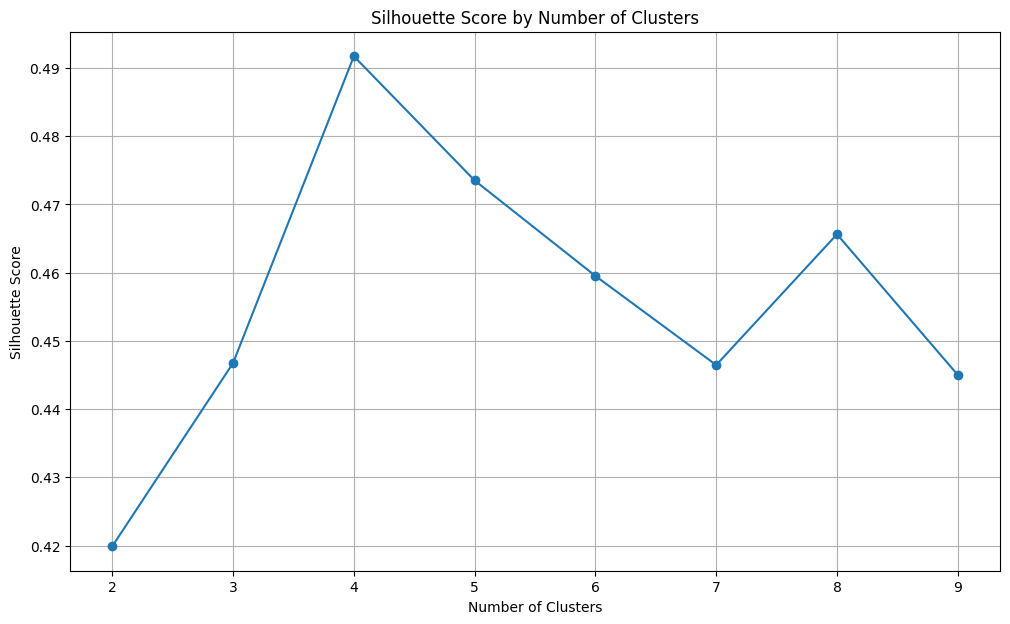


 The optimal number of clusters is, according to the silhouette score:  4.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-25-db52c050065e>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_df_cleaned['cluster'] = kmeans.fit_predict(PCA_df_cleaned)


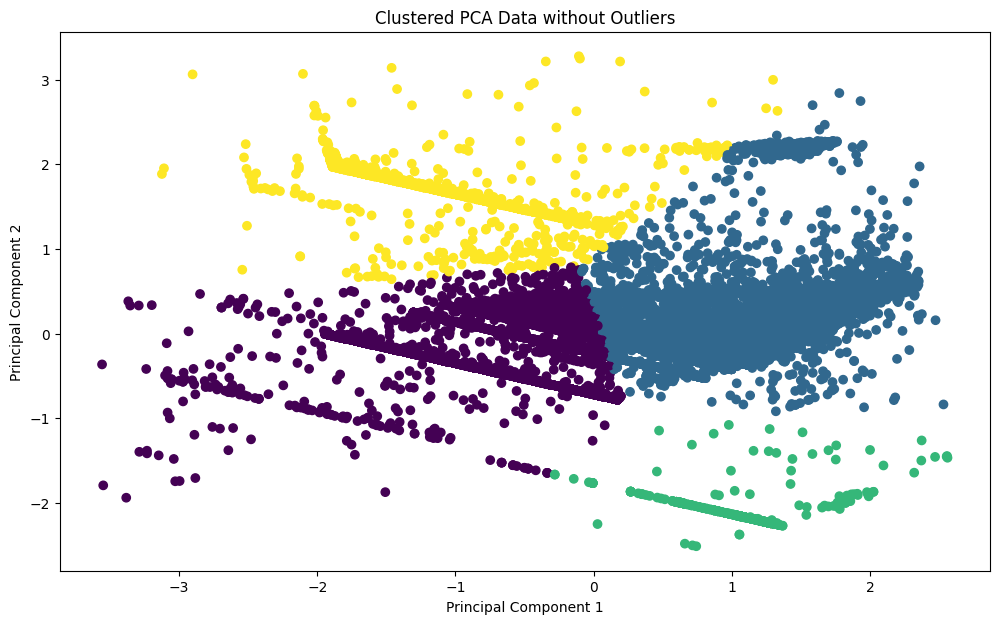

In [ ]:
statisticsDF = pd.read_csv("/content/drive/MyDrive/ADA_HKxML/OG_statistics.csv", nrows = 15000)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# Assuming statisticsDF is your original DataFrame with the statistics
feature_list = statisticsDF.columns[2:]

# Standardize the features
features = statisticsDF[feature_list].values
features = StandardScaler().fit_transform(features)

"""---------------------
PCA with outlier removal
---------------------"""

# Perform PCA on the standardized features
PCA_df = pd.DataFrame(PCA(n_components=2, random_state=42).fit_transform(features), columns=["PCA_Feature_1", "PCA_Feature_2"])

# Calculate Z-scores for each PCA feature
z_scores = np.abs(stats.zscore(PCA_df))

# Define a mask for data points that are within 3 standard deviations
mask = (z_scores < 3).all(axis=1)

# Remove outliers using the mask
PCA_df_cleaned = PCA_df[mask]

"""---------------------
Silhouette score computation
---------------------"""

# DataFrame to store the number of clusters and corresponding silhouette score
silhouette_scores = pd.DataFrame()

# Compute silhouette score for each number of clusters using PCA transformed features without outliers
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, n_init=5, random_state=42)
    cluster_labels = kmeans.fit_predict(PCA_df_cleaned)
    silhouette_avg = silhouette_score(PCA_df_cleaned, cluster_labels)
    silhouette_scores = pd.concat(
        [silhouette_scores, pd.DataFrame({'num_clusters': [i], 'silhouette_score': [silhouette_avg]})],
        ignore_index=True
    )

# Plot the silhouette scores
plt.figure(figsize=(12, 7))
plt.plot(silhouette_scores['num_clusters'], silhouette_scores['silhouette_score'], marker='o')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 10))
plt.grid(True)
plt.show()

# Find the number of clusters with the highest silhouette score
optimal_clusters = silhouette_scores.iloc[silhouette_scores['silhouette_score'].idxmax()]['num_clusters']
print("\n The optimal number of clusters is, according to the silhouette score: ", optimal_clusters)

"""-------------
Applying K-means
------------"""

# Apply K-Means with the optimal number of clusters using PCA transformed features without outliers
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
PCA_df_cleaned['cluster'] = kmeans.fit_predict(PCA_df_cleaned)

# Optional: Plot the clustered data
plt.figure(figsize=(12, 7))
plt.scatter(PCA_df_cleaned['PCA_Feature_1'], PCA_df_cleaned['PCA_Feature_2'], c=PCA_df_cleaned['cluster'], cmap='viridis')
plt.title('Clustered PCA Data without Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


**Rationale:** We first standardized a set of features from a dataset and then applied Principal Component Analysis (PCA) to reduce their dimensionality, focusing on the two most significant components. During the PCA process, we identified and removed outliers based on Z-scores to ensure a cleaner dataset.

After dimension reduction, we started with the clustering algorithm. To ascertain the ideal number of clusters, we relied on maximizing the silhouette score—a metric assessing how closely an object aligns with its own cluster relative to neighboring clusters. We found, that the optimal number of clusters is 4. Finally, we applied KMeans clustering with the identified optimal number of clusters (4) to the cleaned dataset and visualized the resulting clusters, showing the data distribution in the reduced feature space.

Note: Due to memory issues, we were not able to run this algorithm for the entire dataset. To run it anyways, we stored the statisticsDF as a csv on our drive and only read the first 15k rows of it.

## Part 5

### Installation of cuDF/cuML/cuGraphs

In [ ]:
!nvidia-smi
!nvcc -V

Wed Dec  6 17:47:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x

!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com


Found existing installation: protobuf 4.25.1
Uninstalling protobuf-4.25.1:
  Successfully uninstalled protobuf-4.25.1
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.1 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.1 which is incompatible.


### Analysis

In [ ]:
import pandas as pd
import ast
import cudf
import cugraph as cg

# Preparing the datframe
bitcoinDF = pd.read_csv( FILENAME,compression="gzip")

start_date = pd.Timestamp(2009, 1, 3, 0, 0)
end_date = pd.Timestamp(2022, 12, 31, 23, 59)

bitcoinDF = bitcoinDF[(bitcoinDF['Time'] >= start_date) & (bitcoinDF['Time'] <= end_date)]

bitcoinDF['Input'] = bitcoinDF['Input'].apply(ast.literal_eval)
bitcoinDF['Output'] = bitcoinDF['Output'].apply(ast.literal_eval)

bitcoinDF = bitcoinDF.explode("Input").explode("Output")
bitcoinDF[["Output","Value"]] = bitcoinDF["Output"].to_list()

cudf_df = cudf.DataFrame.from_pandas(bitcoinDF[["Input", "Output"]])

# Create a graph using cuGraph
G = cg.from_cudf_edgelist(cudf_df, source='Input', destination='Output', create_using=cg.Graph(directed = False))

# Basic graph analysis using cuGraph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 2996819
Number of edges: 10165163


In [ ]:
import time
start_time = time.time()

def compute_centrality(G):
  # Compute Degree Centrality
  Degree_centrality = cg.degree_centrality(G)

  # Compute Betweenness Centrality
  Betweenness_centrality = cg.degree_centrality(G,100)

  # Compute Katz Centrality
  Katz_centrality = cg.katz_centrality(G)

  # Compute PageRank Centrality
  PageRank_centrality = cg.pagerank(G, tol = 0.001)

  # Compute Eigenvector Centrality
  Eigenvector_centrality = cg.eigenvector_centrality(G)

  return(Degree_centrality, Betweenness_centrality, Katz_centrality, PageRank_centrality, Eigenvector_centrality)

# printing the computed centralities
def print_centrality(Centrality, n):
  Top_Degree_centrality = Centrality[0].sort_values(by = "degree_centrality", ascending = False).head(n).to_pandas
  Top_Betweenness_centrality = Centrality[1].sort_values(by = "degree_centrality", ascending = False).head(n).to_pandas
  Top_Katz_centrality = Centrality[2].sort_values(by = "katz_centrality", ascending = False).head(n).to_pandas
  Top_PageRank_centrality = Centrality[3].sort_values(by = "pagerank", ascending = False).head(n).to_pandas
  Top_Eigenvector_centrality = Centrality[4].sort_values(by = "eigenvector_centrality", ascending = False).head(n).to_pandas

  print("The centrality scores for the top", n, " in each category are:" )

  print("\nDegree Centrality:")
  print(Top_Degree_centrality)

  print("\nBetweenness Centrality:")
  print(Top_Betweenness_centrality)

  print("\nKatz Centrality:")
  print(Top_Katz_centrality)

  print("\nPagerank Centrality:")
  print(Top_PageRank_centrality)

  print("\nEigenvalue Centrality:")
  print(Top_Eigenvector_centrality)

print_centrality(compute_centrality(G), 3)

end_time = time.time()
print("\nRuntime = " + str(end_time - start_time) + "s\n")

/usr/local/lib/python3.10/dist-packages/cugraph/centrality/katz_centrality.py:121: UserWarning: Katz centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cugraph/centrality/eigenvector_centrality.py:88: UserWarning: Eigenvector centrality expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


The centrality scores for the top 3  in each category are:

Degree Centrality:
<bound method DataFrame.to_pandas of          degree_centrality                             vertex
1419935           0.085208  1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
1367386           0.080658  1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
681505            0.032472  1dice9wcMu5hLF4g81u8nioL5mmSHTApw>

Betweenness Centrality:
<bound method DataFrame.to_pandas of          degree_centrality                             vertex
1419167           0.085208  1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
1367994           0.080658  1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
682385            0.032472  1dice9wcMu5hLF4g81u8nioL5mmSHTApw>

Katz Centrality:
<bound method DataFrame.to_pandas of       katz_centrality                             vertex
7727         0.000866  1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
7712         0.000851  1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
7713         0.000688  1dice9wcMu5hLF4g81u8nioL5mmSHTApw>

Pagerank Centrality:
<bound method Data

**Rationale:**

In the realm of network analysis, centrality metrics play a pivotal role in understanding the influence and prominence of nodes within a network. Particularly in financial networks, such as Bitcoin transactions, analyzing centrality can unearth patterns and key players in the transaction landscape.

Consider a graph where nodes represent Bitcoin addresses and edges represent transactions between them. The *degree centrality* scores indicate how active certain addresses are. Address *1dice97ECuByXAvqXpaYzSaQuPVvrtmz6*, with a high score, suggests it's a hub with numerous transactions. Additionally, the *betweenness centrality* also reveals that address *1dice97ECuByXAvqXpaYzSaQuPVvrtmz6* as critical bridges in the transaction paths, possibly indicating a facilitator or an exchange. **What label does this address have?**

Even by looking at the scores using *Katz centrality*, accounting for both direct and indirect connections, the significance of address *1dice97ECuByXAvqXpaYzSaQuPVvrtmz6* due to its connectivity to influential nodes is highlighted. *Pagerank centrality*, as well as *Eigenvalue centrality*, cements the status of address *1dice97ECuByXAvqXpaYzSaQuPVvrtmz6* as supremely influential.

In conclusion, these centrality metrics shed light on the underlying structure of the Bitcoin transaction network, identifying not just the most active addresses, but also those that play crucial roles in the network's connectivity and flow of currency. This analysis, powered by the speed of GPU computation, opens up avenues for understanding economic behavior on the blockchain, highlighting key participants and mapping the financial topography of digital currencies. The runtime of this algorithm for the entire graph, consisting of 2.996.819 nodes and 10.165.163 edges is due to the power of cuGraph only slightly above one second.

## Part 6
Predict future Bitcoin block heights using time series data and analyze their impact on transaction values to understand the relationship between blockchain growth and economic activity.

Number of nodes: 336
Number of edges: 623


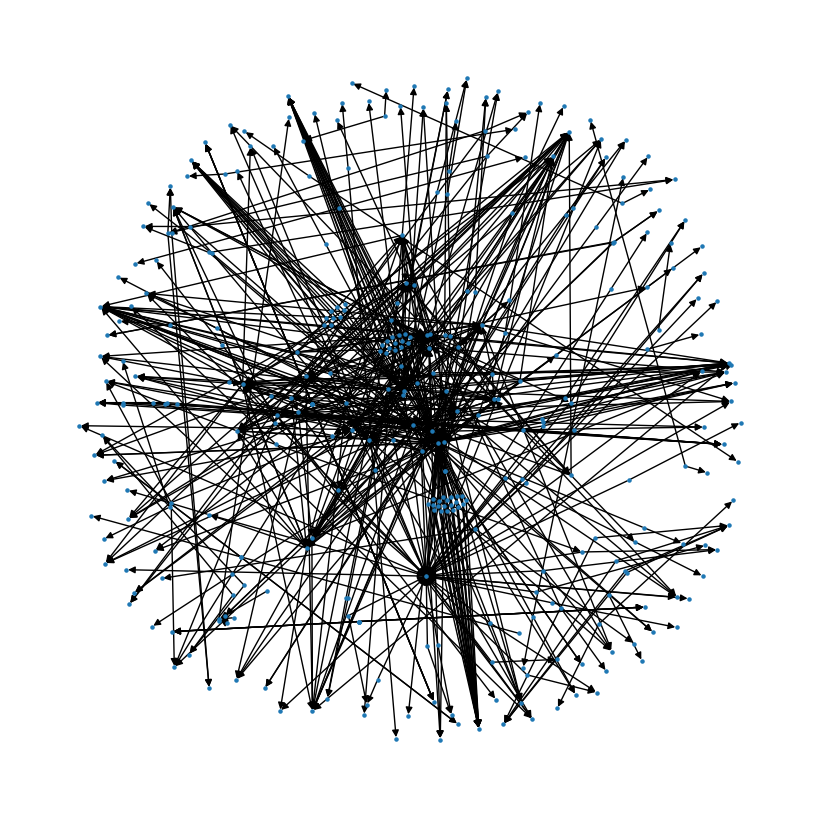

Longest path considering weights is: ['15n7reKKc4rfKAr46QbquVJCnWQe397WAi', '1NASeKtwJfg4iuVjVXVAsrenMrBpdCA2su']
The length of the longest path is: 163.38203222
Longest path considering number of nodes is: ['13HFqPr9Ceh2aBvcjxNdUycHuFG7PReGH4', '19miTEZGYbd4uYEUCS1d4UAt7QSzz7AgwG', '1dice7W2AicHosf5EL3GFDUVga7TgtPFn', '1J4yuJFqozxLWTvnExR4Xxe9W4B89kaukY', '15fXdTyFL1p53qQ8NkrjBqPUbPWvWmZ3G9', '14719bzrTyMvEPcr7ouv9R8utncL9fKJyf', '15FV5Qb1AU4EndwFDh8kVb9vanPh2VvCQa', '1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx', '14ChPPM8rPYJeHnw6kMVUDnNNKx1KnjYW4', '1HjDauL2kth6KJUz5vX198Nvp1xN1hgYRb', '12Cf6nCcRtKERh9cQm3Z29c9MWvQuFSxvT', '18czPiA9PcCs7rFTBZnhvNAWuh1pEZRpGJ', '1HZHBnH2FbHNWieMxAh4xBPfgfuxW15UPt', '1HVpyjYEPwQhvRQ3dL8tGe9kiydti616sX', '1Bqm5MDo82m1FTxV3qYNUUEKnESPRhk9jd', '1AdN2my8NxvGcisPGYeQTAKdWJuUzNkQxG', '1KGBhwojYViF3rL7x85rmoQve7ohwaGgo9']


In [37]:
import networkx as nx

df_short = df[['TxId','Height','Input','Output','Sum','Time']][:200]

# CREATE AN OVERVIEW NETWORK CONNECTIONS
bitcoinDF = df_short.explode('Input').explode('Output')
bitcoinDF[["Output","Value"]] = bitcoinDF["Output"].to_list()

# MAP NETWORK CONNECTIONS IN A GRAPH USING NETWORKX
G = nx.DiGraph()

for _, row in bitcoinDF.iterrows():
    G.add_edge(row['Input'], row['Output'], weight=row['Value'])


# REMOVE CYCLES
def remove_cycles(directed_graph):
    try:
        while True:
            cycle_edges = nx.find_cycle(directed_graph, orientation='original')

            directed_graph.remove_edge(cycle_edges[0][0], cycle_edges[0][1])
    except nx.NetworkXNoCycle:

        return directed_graph

G = remove_cycles(G)

# NETWORKX METRICS
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# DISPLAY
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=5)
plt.show()

# PATH METRICS
longest_path = nx.dag_longest_path(G)
longest_path_length = nx.dag_longest_path_length(G)
longest_path_weight = nx.dag_longest_path(G, weight='Value')


print(f"Longest path considering weights is: {longest_path}")
print(f"The length of the longest path is: {longest_path_length}")
print("Longest path considering number of nodes is:", longest_path_weight)

**Rationale**: As we already looked at the centrality of the nodes in our graph, we also found it extremely intresting to look at the longest path, building on the concept of velocity of money. In contrast to shortest path algorithms, such as Dijkstra, we first have to eliminate all cycles in the graph when solving the longest path problem, because we would end up in a never ending loop otherwise. Once we have done so, we can use the inbuilt functions from the networkx library.

Note, that there are two definitions of longest path.
1. Longest path in terms of total value
2. Longest path in terms of total number of nodes

We computed both and the result is shown above.